### 统计生命周期信息
绘制生命周期时间线图、内存访问图（以时间为X轴，内存地址空间为Y轴），统计运行总时间，计算实际活跃率

#### 1. 读取、预处理数据

In [19]:
results_dir = "results"
page_size_byte = 4096

In [ ]:
import pandas as pd
from sqlalchemy import create_engine

# 使用SQLAlchemy连接
engine = create_engine('sqlite:///data/simpleconvolution/1_save_memory.sqlite3')  # 注意路径格式：sqlite:///
df = pd.read_sql_table('trace', engine)
print(df.columns)
print(df.head())

Index(['ID', 'ParentID', 'Kind', 'What', 'Location', 'StartTime', 'EndTime',
       'DeviceID', 'PID', 'Address', 'ByteSize'],
      dtype='object')
                     ID       ParentID     Kind  \
0         28596_req_out   28596@Driver  req_out   
1         26537_req_out          26537  req_out   
2         28597_req_out          28597  req_out   
3  92395@GPU[1].DRAM[0]  92395_req_out   req_in   
4  92396@GPU[1].DRAM[0]  92396_req_out   req_in   

                              What                 Location  StartTime  \
0                 *mem.AllocateReq                   Driver   0.000015   
1  *protocol.MemoryAllocateTrigger  GPU[1].CommandProcessor   0.000015   
2      *protocol.MemoryAllocateRsp                   Driver   0.000015   
3                    *mem.WriteReq           GPU[1].DRAM[0]   0.000024   
4                    *mem.WriteReq           GPU[1].DRAM[0]   0.000024   

    EndTime  DeviceID  PID     Address  ByteSize  
0  0.000015         1    1  4294971392    262144

In [21]:
# 向量化计算页范围
df['StartPage'] = df['Address'] // 4096
df['EndPage'] = (df['Address'] + df['ByteSize'] - 1) // 4096

# 筛选出内存相关的请求
mem_df = df[ df['What'].isin(['*mem.AllocateReq', '*mem.FreeReq']) | 
                df['What'].isin(['*mem.ReadReq', '*mem.WriteReq']) & 
                    ((df['Location'].str.contains('DRAM', na=False)) 
                    #  | (df['Location'].str.contains('L1', na=False)) 
                    #  | (df['Location'].str.contains('L2', na=False)) 
                    #  | (df['Location'].str.contains('DMA', na=False)) 
                    #  | (df['Kind'].str.contains('req_out') & (df['Location'].str.contains('AddrTrans', na=False)))
                    )
            ]

# print(mem_df[mem_df['What'].isin(['*mem.FreeReq'])])

# 生成所有页的访问记录
rows = []
for _, row in mem_df.iterrows():
    for page in range(row['StartPage'], row['EndPage'] + 1):
        rows.append({
            'DeviceID': row['DeviceID'],
            # 'PID': row['PID'],
            'PageID': page,
            'AccessType': row['What'],
            'StartTime': row['StartTime'],
            'EndTime': row['EndTime'],
        })

page_access_df = pd.DataFrame(rows)
print(page_access_df)
# print(page_access_df[page_access_df['AccessType'].isin(['*mem.FreeReq'])])


       DeviceID   PageID        AccessType  StartTime   EndTime
0             1  1048577  *mem.AllocateReq   0.000015  0.000015
1             1  1048578  *mem.AllocateReq   0.000015  0.000015
2             1  1048579  *mem.AllocateReq   0.000015  0.000015
3             1  1048580  *mem.AllocateReq   0.000015  0.000015
4             1  1048581  *mem.AllocateReq   0.000015  0.000015
...         ...      ...               ...        ...       ...
16545         1  1048701      *mem.FreeReq   0.000126  0.000126
16546         1  1048702      *mem.FreeReq   0.000126  0.000126
16547         1  1048703      *mem.FreeReq   0.000126  0.000126
16548         1  1048704      *mem.FreeReq   0.000126  0.000126
16549         1  1048705      *mem.FreeReq   0.000126  0.000126

[16550 rows x 5 columns]


#### 2. 处理内存访问数据

In [22]:
# 按 PageID 分组，计算各页面的关键时间指标
rw_df = page_access_df[page_access_df['AccessType'].isin(['*mem.ReadReq', '*mem.WriteReq'])]
print(rw_df)

page_rw_stats_df = rw_df.groupby('PageID').agg({
    'StartTime': ['min'],
    "EndTime": ['max'],
    'AccessType': lambda x: list(x.unique())  # 记录所有操作类型
}).reset_index()
page_rw_stats_df.columns = ['PageID', 'FirstAccessTime', 'LastAccessTime', 'AccessTypes']

# 添加生命周期持续时间列
page_rw_stats_df['ActualLifeDuration'] = page_rw_stats_df['LastAccessTime'] - page_rw_stats_df['FirstAccessTime']

print(page_rw_stats_df)

       DeviceID   PageID     AccessType  StartTime   EndTime
64            0  1048577  *mem.WriteReq   0.000024  0.000025
65            0  1048577  *mem.WriteReq   0.000024  0.000025
66            0  1048577  *mem.WriteReq   0.000024  0.000025
67            0  1048577  *mem.WriteReq   0.000024  0.000025
68            0  1048577  *mem.WriteReq   0.000024  0.000025
...         ...      ...            ...        ...       ...
16481         0  1048704   *mem.ReadReq   0.000126  0.000126
16482         0  1048704   *mem.ReadReq   0.000126  0.000126
16483         0  1048704   *mem.ReadReq   0.000126  0.000126
16484         0  1048704   *mem.ReadReq   0.000126  0.000126
16485         0  1048705   *mem.ReadReq   0.000126  0.000126

[16286 rows x 5 columns]
      PageID  FirstAccessTime  LastAccessTime                    AccessTypes  \
0    1048577         0.000024        0.000096  [*mem.WriteReq, *mem.ReadReq]   
1    1048578         0.000025        0.000096  [*mem.WriteReq, *mem.ReadReq]   
2 

#### 3. 处理内存分配/释放数据

In [23]:
# 筛选分配和释放请求
af_df = page_access_df[page_access_df['AccessType'].isin(['*mem.AllocateReq', '*mem.FreeReq'])]

# 提取分配时间（每个 PageID 的最小 StartTime）
alloc_df = af_df[af_df['AccessType'] == '*mem.AllocateReq'].groupby('PageID')['StartTime'].min().reset_index()
alloc_df.columns = ['PageID', 'AllocateTime']

# 提取释放时间（每个 PageID 的最大 StartTime）
free_df = af_df[af_df['AccessType'] == '*mem.FreeReq'].groupby('PageID')['StartTime'].max().reset_index()
free_df.columns = ['PageID', 'FreeTime']

# 合并分配、释放和读写统计
page_af_stats_df = pd.merge(alloc_df, free_df, on='PageID', how='left')

# 计算最大时间用于未释放页面的填充
max_end_time = df['EndTime'].max()
print(f"Max End Time: {max_end_time}")

# 填充未释放页面的FreeTime
page_af_stats_df['FreeTime'] = page_af_stats_df['FreeTime'].fillna(max_end_time)

# 添加生命周期持续时间列
page_af_stats_df['LifeDuration'] = page_af_stats_df['FreeTime'] - page_af_stats_df['AllocateTime']

print(af_df)
print(page_af_stats_df)

Max End Time: 0.000126437
       DeviceID   PageID        AccessType  StartTime   EndTime
0             1  1048577  *mem.AllocateReq   0.000015  0.000015
1             1  1048578  *mem.AllocateReq   0.000015  0.000015
2             1  1048579  *mem.AllocateReq   0.000015  0.000015
3             1  1048580  *mem.AllocateReq   0.000015  0.000015
4             1  1048581  *mem.AllocateReq   0.000015  0.000015
...         ...      ...               ...        ...       ...
16545         1  1048701      *mem.FreeReq   0.000126  0.000126
16546         1  1048702      *mem.FreeReq   0.000126  0.000126
16547         1  1048703      *mem.FreeReq   0.000126  0.000126
16548         1  1048704      *mem.FreeReq   0.000126  0.000126
16549         1  1048705      *mem.FreeReq   0.000126  0.000126

[264 rows x 5 columns]
      PageID  AllocateTime  FreeTime  LifeDuration
0    1048577      0.000015  0.000108      0.000092
1    1048578      0.000015  0.000108      0.000092
2    1048579      0.000015  0

#### 4. 绘制内存占用时间线图

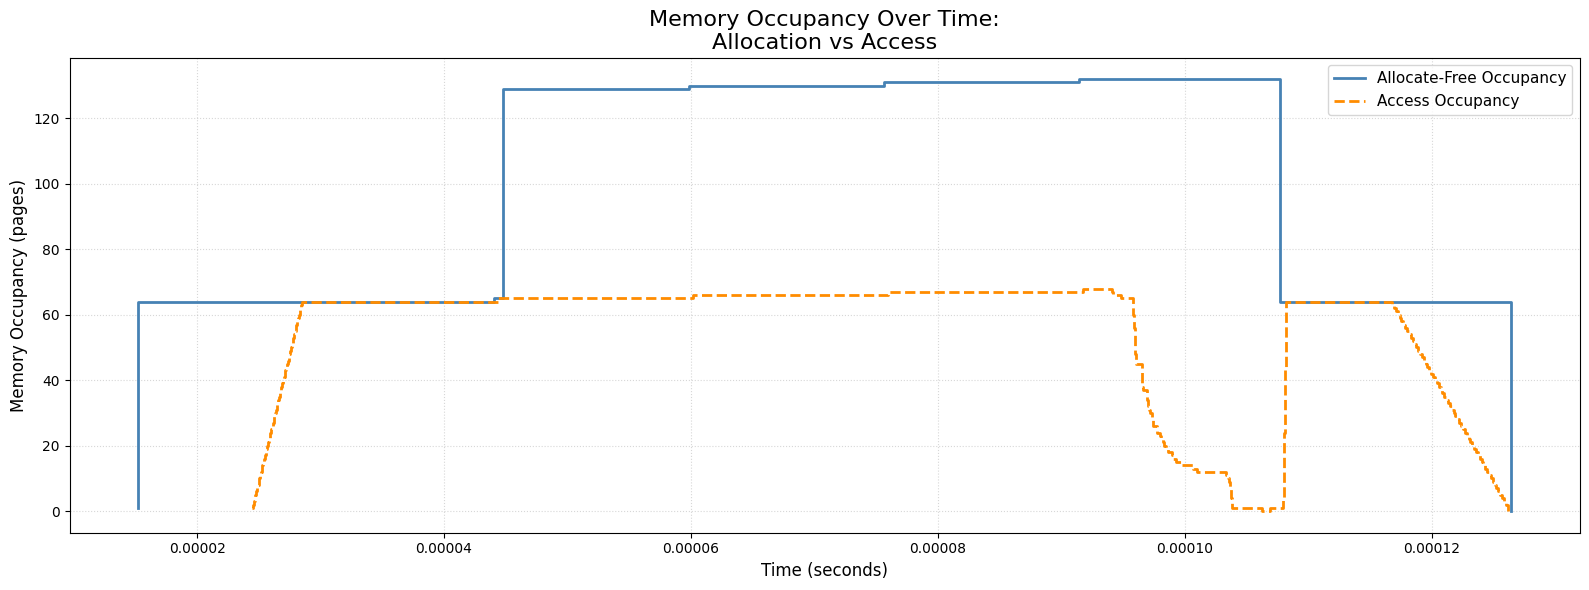

In [24]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

# 构建“Allocate - Free”事件列表
alloc_events = []
for _, row in page_af_stats_df.iterrows():
    alloc_events.append((row['AllocateTime'], 1))   # 分配 +1
    alloc_events.append((row['FreeTime'], -1))      # 释放 -1
alloc_events.sort()

# 构建“FirstAccess - LastAccess”事件列表
access_events = []
for _, row in page_rw_stats_df.iterrows():
    access_events.append((row['FirstAccessTime'], 1))   # 首次访问 +1
    access_events.append((row['LastAccessTime'], -1))   # 最后访问 -1
access_events.sort()

# 生成时间和占用曲线
def compute_occupancy(events):
    times = []
    usages = []
    current = 0
    for time, delta in events:
        times.append(time)
        current += delta
        usages.append(current)
    return times, usages

alloc_times, alloc_usage = compute_occupancy(alloc_events)
access_times, access_usage = compute_occupancy(access_events)

# 绘图
plt.figure(figsize=(16, 6))
plt.step(alloc_times, alloc_usage, where='post', label='Allocate-Free Occupancy', color='steelblue', linewidth=2)
plt.step(access_times, access_usage, where='post', label='Access Occupancy', color='darkorange', linewidth=2, linestyle='--')

# 图表设置
plt.xlabel('Time (seconds)', fontsize=12)
plt.ylabel('Memory Occupancy (pages)', fontsize=12)
plt.title('Memory Occupancy Over Time:\nAllocation vs Access', fontsize=16)
plt.grid(True, linestyle=':', alpha=0.5)
plt.legend(fontsize=11)

# 保存或展示
occupancy_compare_path = os.path.join(results_dir, 'memory_occupancy_compare.png')
plt.savefig(occupancy_compare_path, dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

#### 5. 计算内存占用

In [25]:
from collections import defaultdict

def compute_occupancy_and_metrics(events, page_size_byte):
    # 将同一时间点的 delta 合并
    delta_dict = defaultdict(int)
    for time, delta in events:
        delta_dict[time] += delta

    # 按时间排序
    sorted_times = sorted(delta_dict.keys())

    times = []
    usages = []
    current_usage = 0

    for t in sorted_times:
        times.append(t)
        current_usage += delta_dict[t]
        usages.append(current_usage)

    # 最大占用
    max_usage_pages = max(usages)
    max_usage_bytes = max_usage_pages * page_size_byte

    # 累积占用：注意 usages[i] 表示在 times[i] 到 times[i+1] 之间的高度
    total_usage_pages = 0
    for i in range(len(times) - 1):
        duration = times[i + 1] - times[i]
        height = usages[i]
        total_usage_pages += height * duration

    total_usage_bytes = total_usage_pages * page_size_byte

    return times, usages, max_usage_pages, max_usage_bytes, total_usage_pages, total_usage_bytes

# 分配-释放轨迹
alloc_times, alloc_usage, alloc_max_p, alloc_max_b, alloc_total_p, alloc_total_b = compute_occupancy_and_metrics(alloc_events, page_size_byte)

# 访问轨迹
access_times, access_usage, access_max_p, access_max_b, access_total_p, access_total_b = compute_occupancy_and_metrics(access_events, page_size_byte)

# 打印结果（带单位）
def format_bytes(size_bytes):
    if size_bytes >= 1024**2:
        return f"{size_bytes / 1024**2:.2f} MB"
    elif size_bytes >= 1024:
        return f"{size_bytes / 1024:.2f} KB"
    else:
        return f"{size_bytes:.2f} B"

# 比例计算
max_ratio = access_max_p / alloc_max_p if alloc_max_p > 0 else 0
total_ratio = access_total_p / alloc_total_p if alloc_total_p > 0 else 0

# 输出结果
print("///分配-释放///")
print(f"最大占用：{alloc_max_p} 页 ({format_bytes(alloc_max_b)})")
print(f"累积占用：{alloc_total_p:.6f} 页×秒 ({format_bytes(alloc_total_b)}·s)")

print("\n///首次访问-最后访问///")
print(f"最大占用：{access_max_p} 页 ({format_bytes(access_max_b)})")
print(f"累积占用：{access_total_p:.6f} 页×秒 ({format_bytes(access_total_b)}·s)")

print("\n///占用比///")
print(f"最大占用比（访问/分配）：{max_ratio:.2%}")
print(f"累积占用比（访问/分配）：{total_ratio:.2%}")

///分配-释放///
最大占用：132 页 (528.00 KB)
累积占用：0.011303 页×秒 (46.30 B·s)

///首次访问-最后访问///
最大占用：68 页 (272.00 KB)
累积占用：0.005566 页×秒 (22.80 B·s)

///占用比///
最大占用比（访问/分配）：51.52%
累积占用比（访问/分配）：49.24%


#### 6. 保存内存访问信息

In [26]:
!pip install xlsxwriter
import os

mem_all_df = df[df['What'].isin(['*mem.AllocateReq', '*mem.FreeReq']) 
            | (df['What'].isin(['*mem.ReadReq', '*mem.WriteReq']) )
            ]
mem_path = os.path.join(results_dir, 'memory_access.xlsx')
# 创建Excel写入器（使用xlsxwriter引擎支持更多格式）
with pd.ExcelWriter(mem_path,
                   engine='xlsxwriter',
                   datetime_format='YYYY-MM-DD HH:MM:SS') as writer:
    
    # 保存mem_df
    mem_df.to_excel(writer, 
                   sheet_name='memory_access',
                   index=False)
    
    # 获取工作表对象进行格式设置
    worksheet1 = writer.sheets['memory_access']
    # 设置列宽自适应
    for idx, col in enumerate(mem_df.columns):
        max_len = max(mem_df[col].astype(str).map(len).max(), len(col)) + 2
        worksheet1.set_column(idx, idx, max_len)
    
    # 保存mem_all_df
    mem_all_df.to_excel(writer, 
                       sheet_name='memory_access_all',
                       index=False)
    
    # 对第二个工作表设置格式
    worksheet2 = writer.sheets['memory_access_all']
    for idx, col in enumerate(mem_all_df.columns):
        max_len = max(mem_all_df[col].astype(str).map(len).max(), len(col)) + 2
        worksheet2.set_column(idx, idx, max_len)

    # 保存rw_df
    rw_df.to_excel(writer, 
                       sheet_name='read_write',
                       index=False)
    
    # 对第三个工作表设置格式
    worksheet3 = writer.sheets['read_write']
    for idx, col in enumerate(rw_df.columns):
        max_len = max(rw_df[col].astype(str).map(len).max(), len(col)) + 2
        worksheet3.set_column(idx, idx, max_len)

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple, https://pypi.ngc.nvidia.com


#### 7. 计算实际活跃率和运行总时间

In [27]:
# 合并两个DataFrame
page_stats_df = pd.merge(
    page_rw_stats_df[['PageID', 'FirstAccessTime', 'LastAccessTime', 'ActualLifeDuration']],
    page_af_stats_df[['PageID', 'AllocateTime', 'FreeTime', 'LifeDuration']],
    on='PageID',
    how='outer'  # 保留所有页面，即使只有一种统计
)

# 计算使用率比率
page_stats_df['UsageRatio'] = page_stats_df['ActualLifeDuration'] / page_stats_df['LifeDuration']

# 填充可能存在的NaN值（当LifeDuration为0时）
page_stats_df['UsageRatio'] = page_stats_df['UsageRatio'].fillna(0)

# 计算总持续时间
total_stats = {
    'TotalAllocatedTime': page_stats_df['LifeDuration'].sum(),
    'TotalActiveTime': page_stats_df['ActualLifeDuration'].sum(),
    'OverallUsageRatio': page_stats_df['ActualLifeDuration'].sum() / page_stats_df['LifeDuration'].sum()
}

print("page_stats_df:")
print(page_stats_df)
print(total_stats)

print("\n实际活跃率 = 实际生命周期 / 生命周期 * 100 = ", total_stats['OverallUsageRatio'] * 100, "%")

simulation_time_df = df[(df['Kind']=='Simulation')& (df['What']=='Simulation') & (df['Location']=='Driver')]
simulation_time = (simulation_time_df['EndTime'] - simulation_time_df['StartTime']).astype(float)
print(f'运行总时间: {simulation_time.iloc[0]:.12f} s')

page_stats_df:
      PageID  FirstAccessTime  LastAccessTime  ActualLifeDuration  \
0    1048577         0.000024        0.000096            0.000071   
1    1048578         0.000025        0.000096            0.000071   
2    1048579         0.000025        0.000096            0.000071   
3    1048580         0.000025        0.000096            0.000071   
4    1048581         0.000025        0.000096            0.000071   
..       ...              ...             ...                 ...   
127  1048704         0.000108        0.000126            0.000018   
128  1048705         0.000107        0.000126            0.000019   
129  1048706         0.000060        0.000095            0.000035   
130  1048707         0.000076        0.000094            0.000018   
131  1048708         0.000092        0.000094            0.000002   

     AllocateTime  FreeTime  LifeDuration  UsageRatio  
0        0.000015  0.000108      0.000092    0.773379  
1        0.000015  0.000108      0.000092   

#### 8. 绘制生命周期时间线图

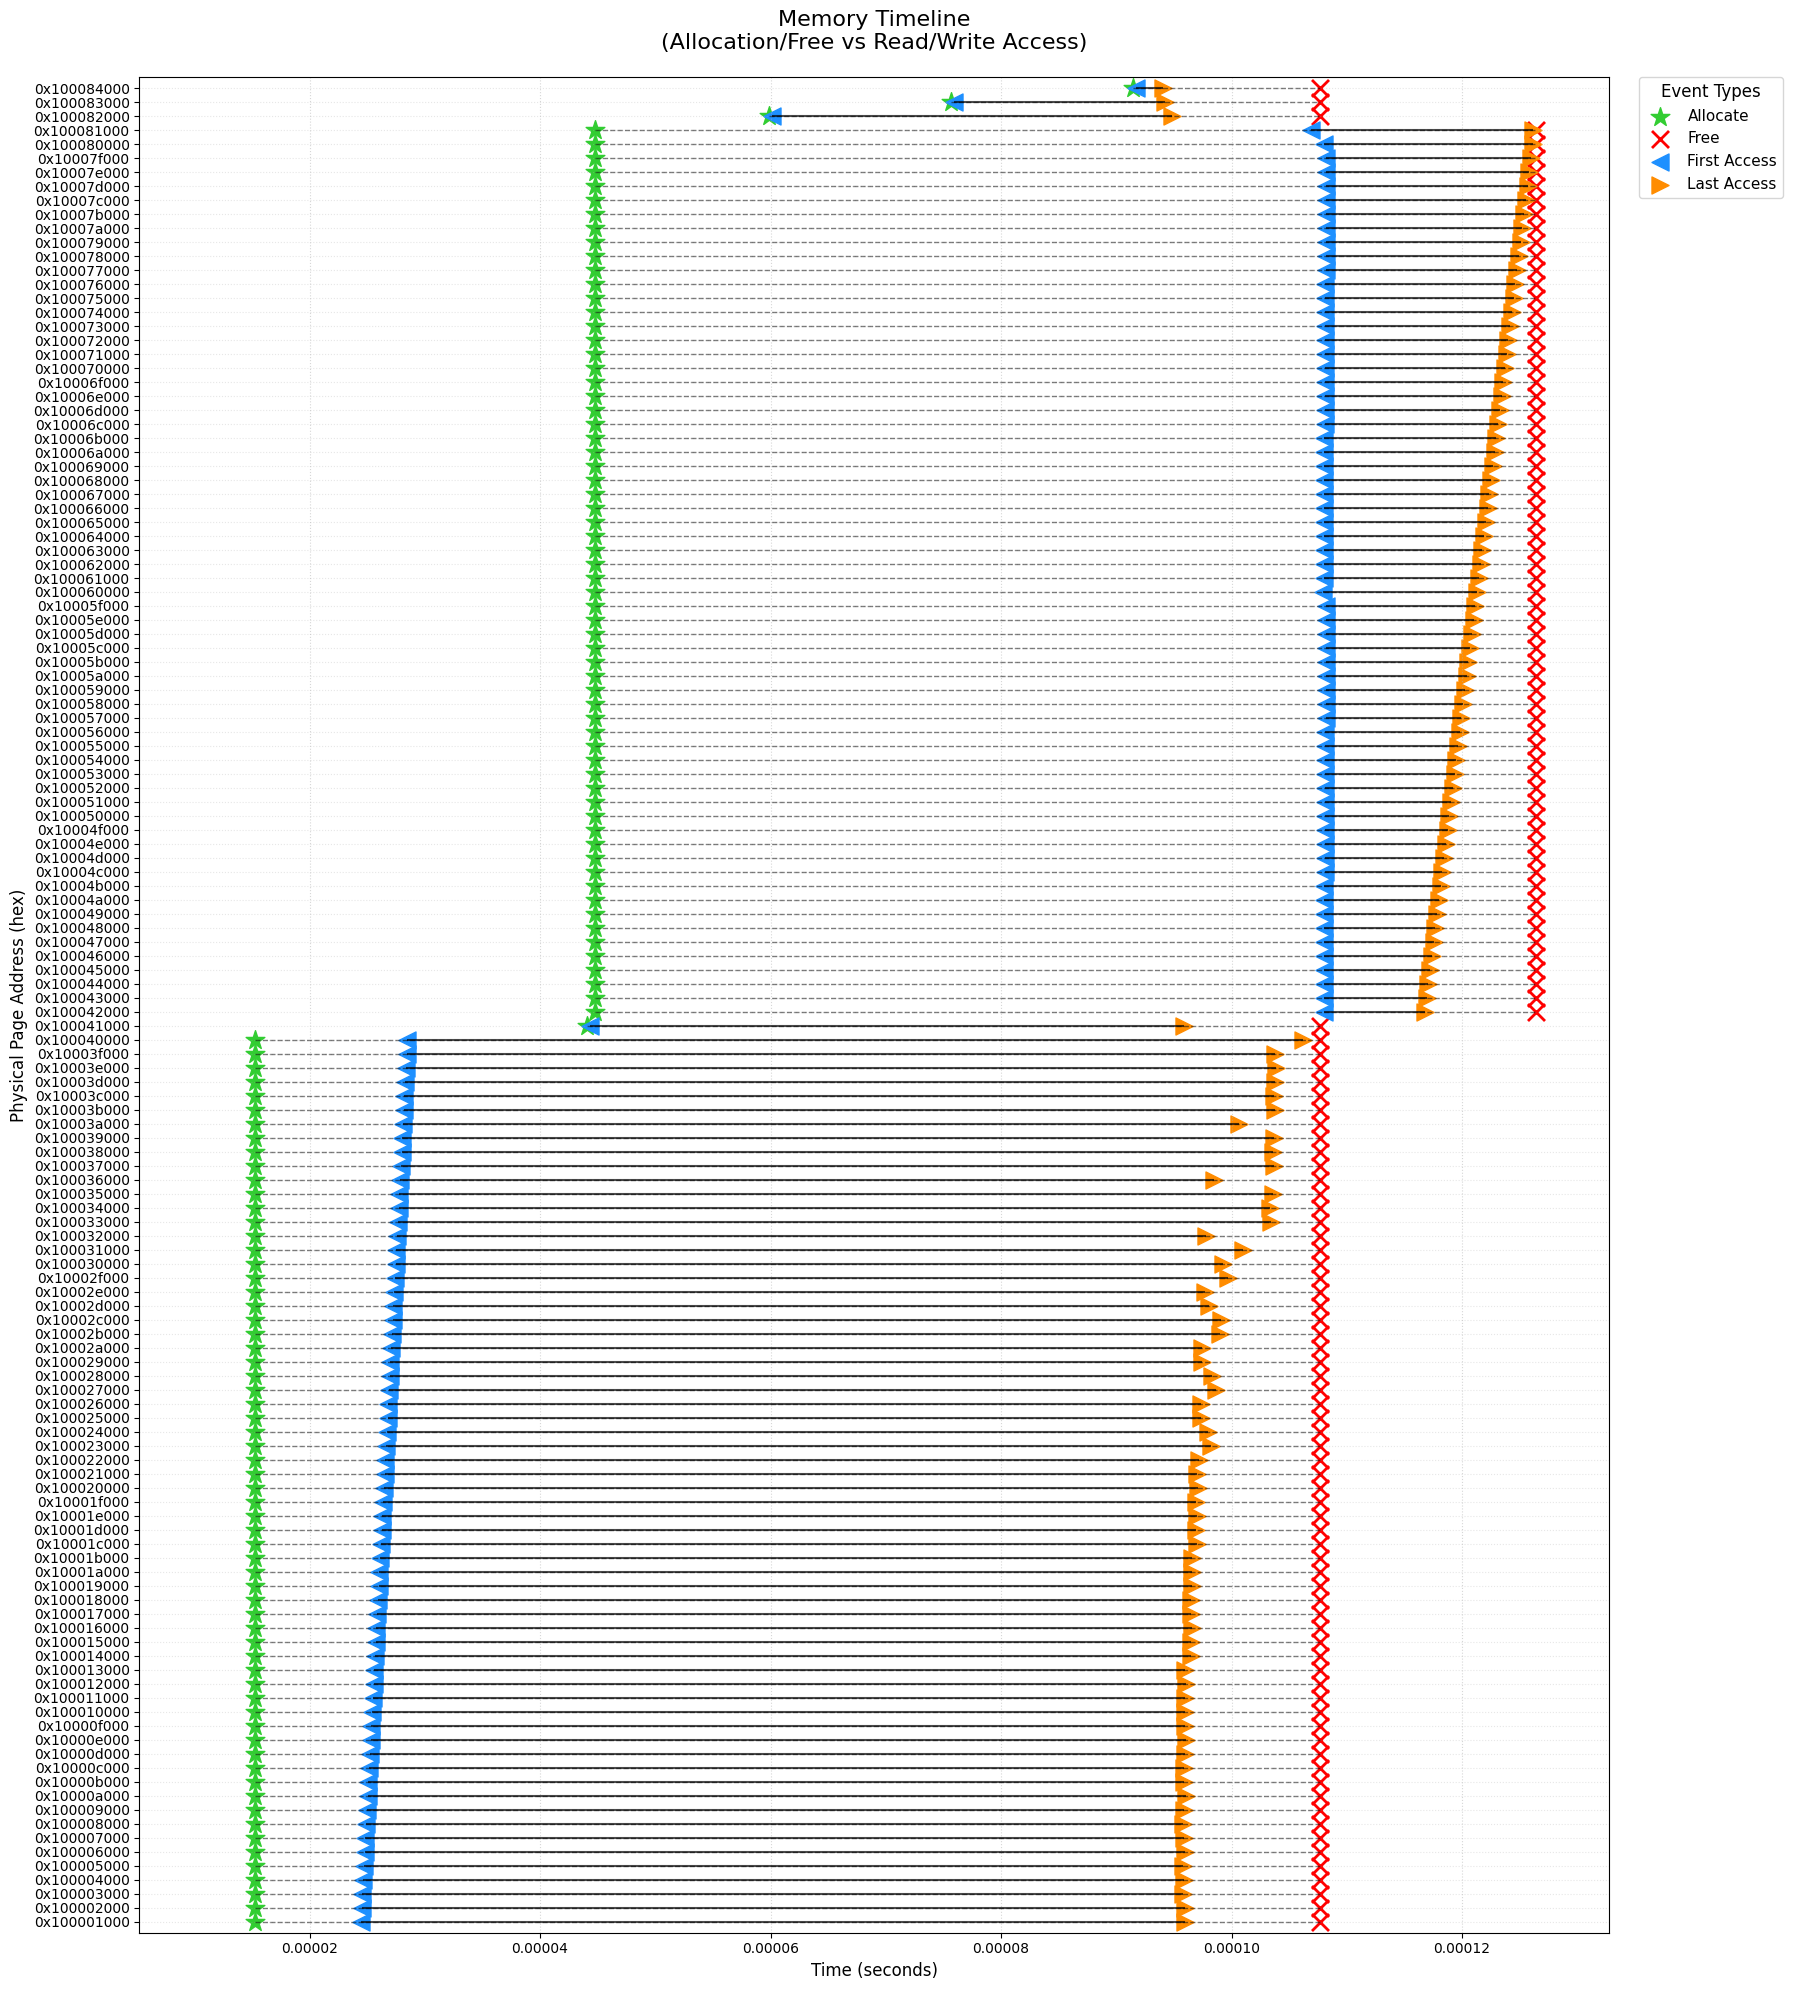

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 20))

# 创建统一的y轴映射
all_pages = sorted(set(page_rw_stats_df['PageID']).union(set(page_af_stats_df['PageID'])))
y_pos_map = {page: i for i, page in enumerate(all_pages)}

# 绘制分配/释放时间线
for _, row in page_af_stats_df.iterrows():
    y_pos = y_pos_map[row['PageID']]
    plt.scatter(row['AllocateTime'], y_pos,
               color='limegreen', marker='*', s=200,
               label='Allocate' if _ == 0 else '')
    plt.scatter(row['FreeTime'], y_pos,
               color='red', marker='x', s=150, linewidth=2,
               label='Free' if _ == 0 else '')
    plt.hlines(y=y_pos,
              xmin=row['AllocateTime'],
              xmax=row['FreeTime'],
              colors='black', linestyles='dashed', alpha=0.5, linewidth=1) # limegreen

# 绘制读写访问时间线
for _, row in page_rw_stats_df.iterrows():
    y_pos = y_pos_map[row['PageID']]
    plt.scatter(row['FirstAccessTime'], y_pos,
               color='dodgerblue', marker='<', s=150,
               label='First Access' if _ == 0 else '')
    plt.scatter(row['LastAccessTime'], y_pos,
               color='darkorange', marker='>', s=150,
               label='Last Access' if _ == 0 else '')
    plt.hlines(y=y_pos,
              xmin=row['FirstAccessTime'],
              xmax=row['LastAccessTime'],
              colors='black', alpha=0.7, linewidth=1.5)

# 设置坐标轴
# plt.yticks(range(len(all_pages)), all_pages, fontsize=10) # y轴显示page id
plt.yticks(range(len(all_pages)), [hex(page * page_size_byte) for page in all_pages], fontsize=10) # y轴显示页物理地址
plt.xticks(fontsize=10)
plt.xlabel('Time (seconds)', fontsize=12)
# plt.ylabel('Page ID', fontsize=12) # y轴显示page id
plt.ylabel('Physical Page Address (hex)', fontsize=12) # y轴显示页物理地址
plt.title('Memory Timeline\n(Allocation/Free vs Read/Write Access)', fontsize=16, pad=20)

# 调整坐标轴范围
min_time = min(page_af_stats_df['AllocateTime'].min(), page_rw_stats_df['FirstAccessTime'].min())
max_time = max(page_af_stats_df['FreeTime'].max(), page_rw_stats_df['LastAccessTime'].max())
plt.xlim(left=min_time-0.00001, right=max_time*1.05)
plt.ylim(bottom=-0.8, top=len(all_pages)-0.2)

# 添加网格线
plt.grid(True, axis='x', linestyle=':', alpha=0.5)
plt.grid(True, axis='y', linestyle=':', alpha=0.3)

# 将图例移到图表右侧外部
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(),
          bbox_to_anchor=(1.02, 1),  # 将图例放在图表右侧外部
          loc='upper left',          # 锚点在左上角
          borderaxespad=0.,          # 与坐标轴的距离
          frameon=True,              # 显示边框
          fontsize=11,               # 增大字体
          title='Event Types',       # 添加图例标题
          title_fontsize=12)         # 图例标题大小

# 调整布局，为图例留出空间
plt.subplots_adjust(right=0.85)  # 为图例留出15%的右侧空间

plt.tight_layout()
timeline_path = os.path.join(results_dir, 'memory_timeline.png')
plt.savefig(timeline_path, dpi=300, bbox_inches='tight')
plt.show()


#### 9. 绘制生命周期时间线+内存访问图

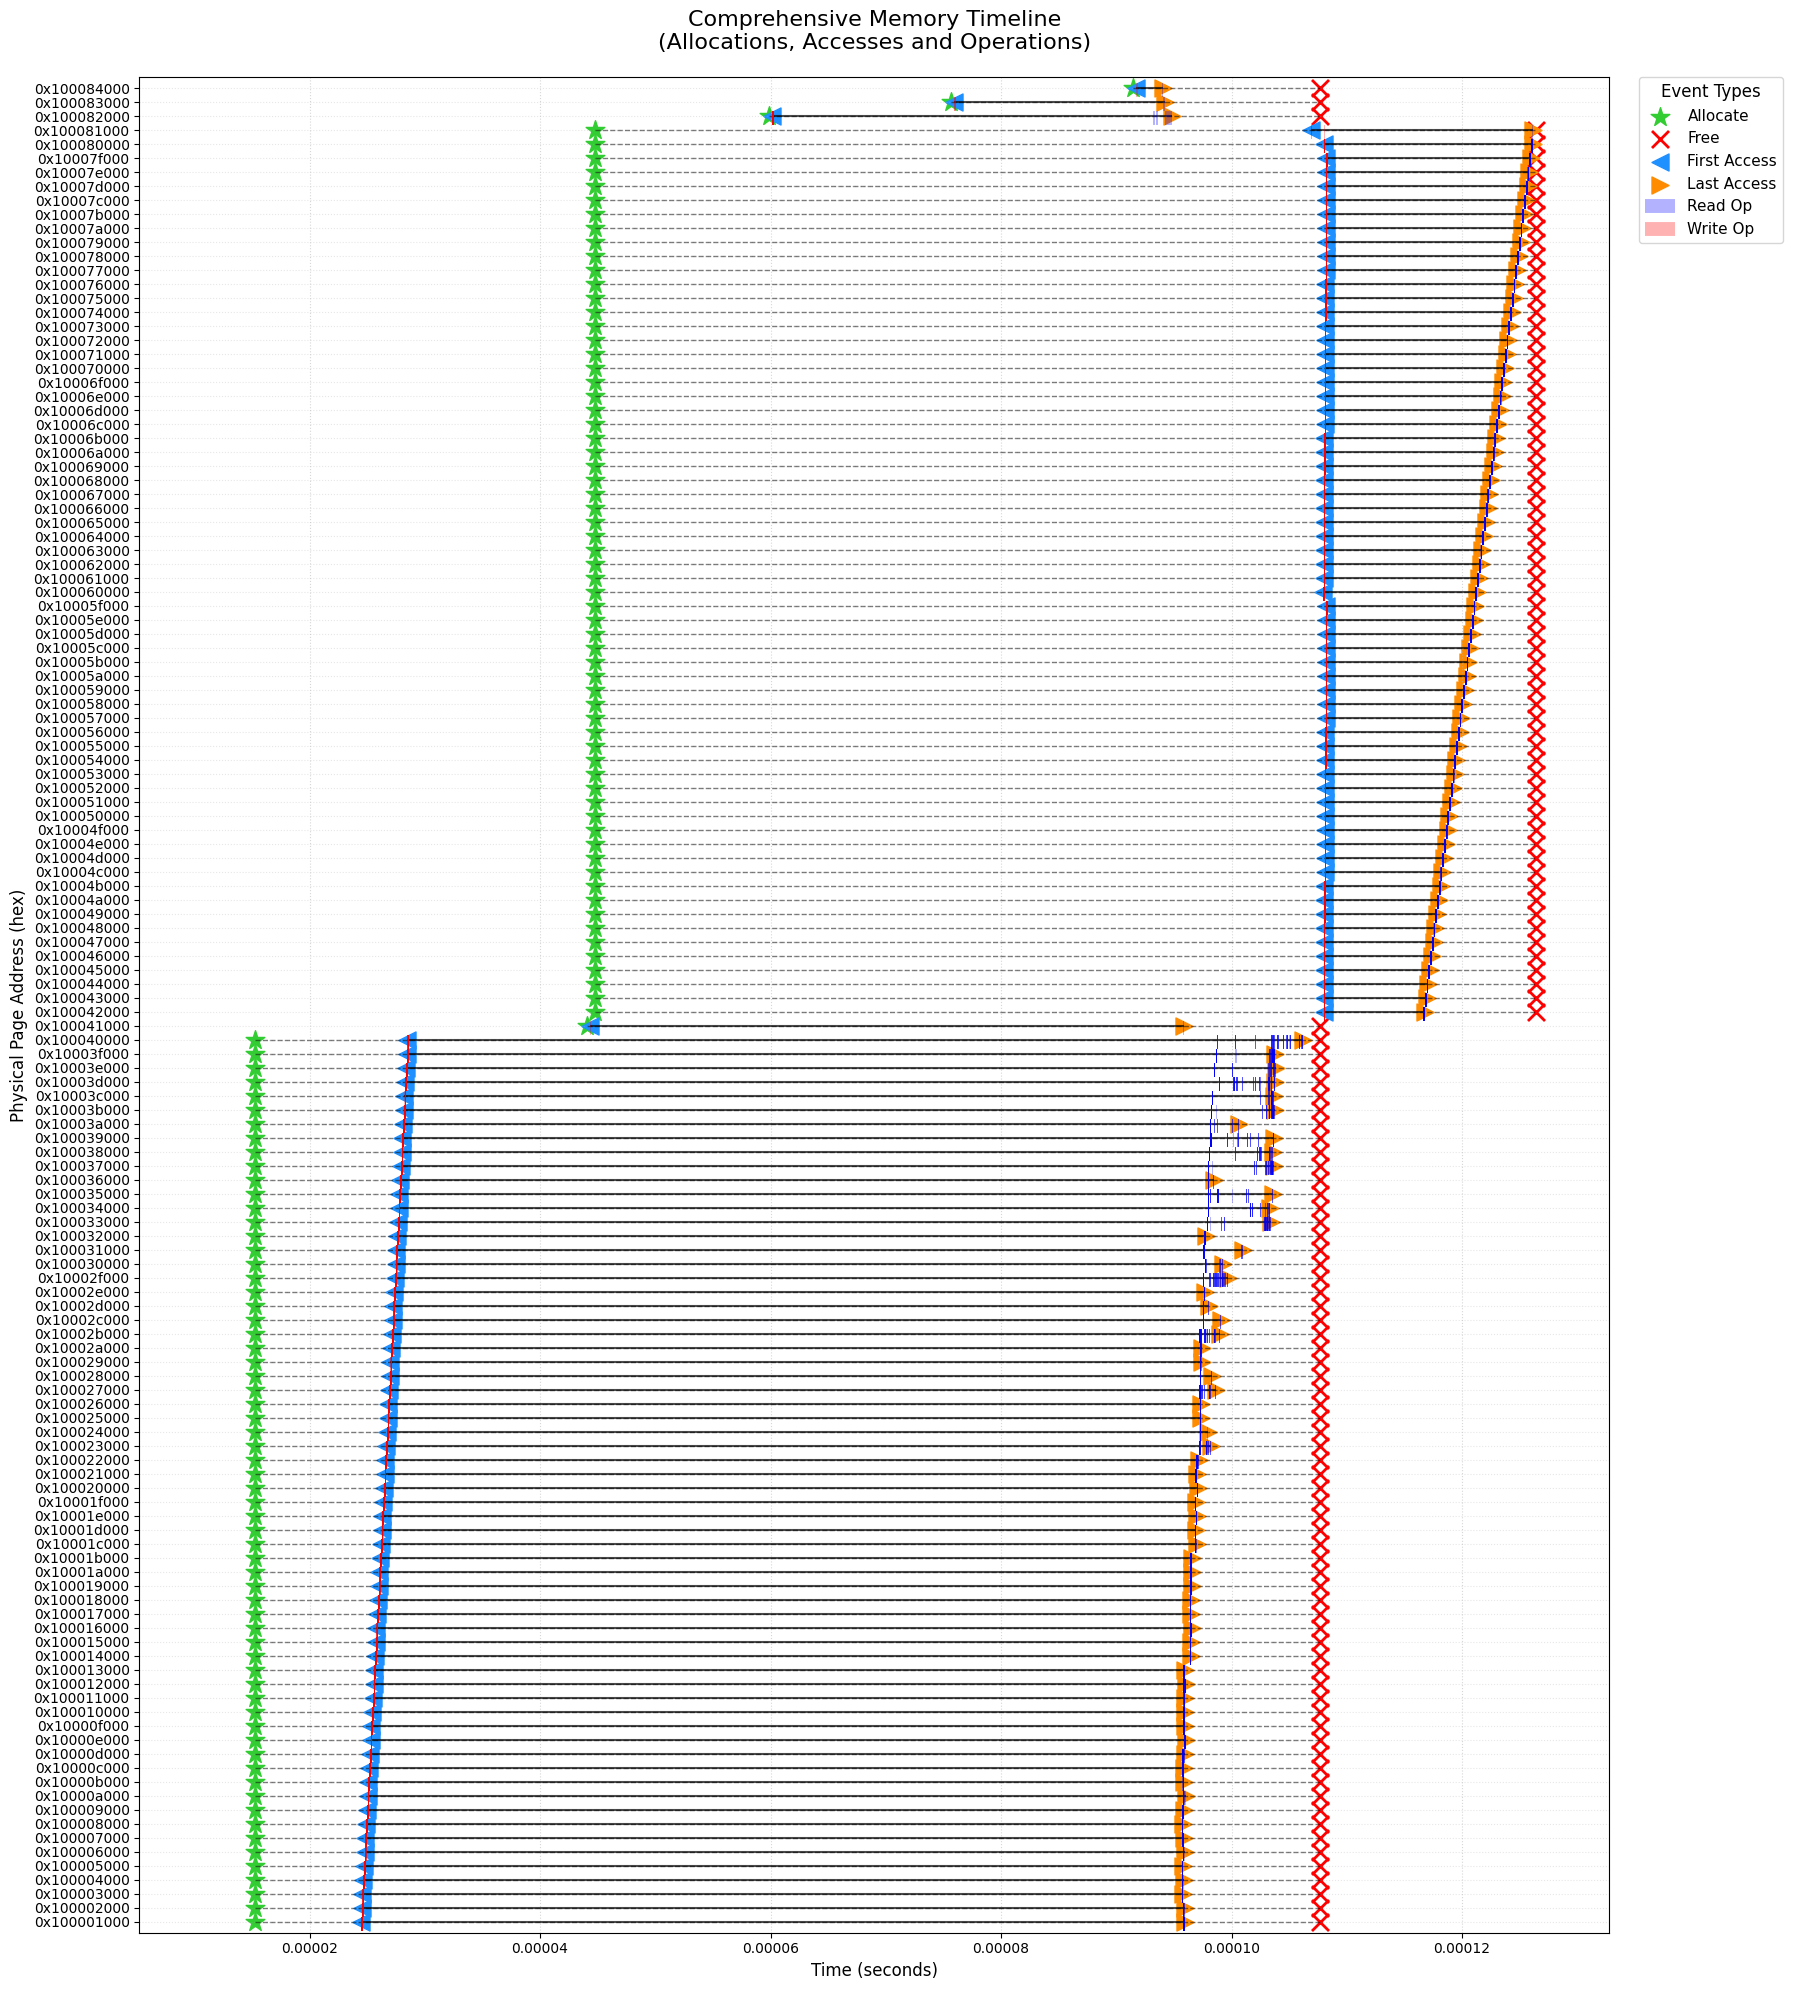

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 20))

# 创建统一的y轴映射（包含所有数据集的PageID）
all_pages = sorted(set(page_rw_stats_df['PageID'])
                  .union(set(page_af_stats_df['PageID']))
                  .union(set(rw_df['PageID'])))
y_pos_map = {page: i for i, page in enumerate(all_pages)}

# ===== 1. 绘制分配/释放时间线 =====
for _, row in page_af_stats_df.iterrows():
    y_pos = y_pos_map[row['PageID']]
    plt.scatter(row['AllocateTime'], y_pos,
               color='limegreen', marker='*', s=200,
               label='Allocate' if _ == 0 else '')
    plt.scatter(row['FreeTime'], y_pos,
               color='red', marker='x', s=150, linewidth=2,
               label='Free' if _ == 0 else '')
    plt.hlines(y=y_pos,
              xmin=row['AllocateTime'],
              xmax=row['FreeTime'],
              colors='black', linestyles='dashed', alpha=0.5, linewidth=1)

# ===== 2. 绘制首次/末次访问时间线 =====
for _, row in page_rw_stats_df.iterrows():
    y_pos = y_pos_map[row['PageID']]
    plt.scatter(row['FirstAccessTime'], y_pos,
               color='dodgerblue', marker='<', s=150,
               label='First Access' if _ == 0 else '')
    plt.scatter(row['LastAccessTime'], y_pos,
               color='darkorange', marker='>', s=150,
               label='Last Access' if _ == 0 else '')
    plt.hlines(y=y_pos,
              xmin=row['FirstAccessTime'],
              xmax=row['LastAccessTime'],
              colors='black', alpha=0.7, linewidth=1.5)

# ===== 3. 绘制详细的读写操作时间线 =====
for _, row in rw_df.iterrows():
    y_pos = y_pos_map[row['PageID']]
    
    # 根据访问类型设置样式
    if row['AccessType'] == '*mem.ReadReq':
        color = 'blue'
        line_alpha = 0.3
        label = 'Read Op' if _ == 0 or 'Read Op' not in plt.gca().get_legend_handles_labels()[1] else ''
    else:
        color = 'red'
        line_alpha = 0.3
        label = 'Write Op' if _ == 0 or 'Write Op' not in plt.gca().get_legend_handles_labels()[1] else ''
    
    # 绘制操作持续时间（横线）
    plt.hlines(y=y_pos - 0.15,
              xmin=row['StartTime'],
              xmax=row['EndTime'],
              colors=color,
              alpha=line_alpha,
              linewidth=10,
              label=label)
    
    # # 在操作开始处添加小标记
    # marker = '|' if row['AccessType'] == '*mem.ReadReq' else 'x'
    # plt.scatter(row['StartTime'], y_pos,
    #            color=color, marker=marker, s=50, alpha=0.8)

# ===== 图表装饰 =====
# 设置坐标轴
# plt.yticks(range(len(all_pages)), all_pages, fontsize=10) # y轴显示page id
plt.yticks(range(len(all_pages)), [hex(page * page_size_byte) for page in all_pages], fontsize=10) # y轴显示页物理地址
plt.xticks(fontsize=10)
plt.xlabel('Time (seconds)', fontsize=12)
# plt.ylabel('Page ID', fontsize=12) # y轴显示page id
plt.ylabel('Physical Page Address (hex)', fontsize=12) # y轴显示页物理地址
plt.title('Comprehensive Memory Timeline\n(Allocations, Accesses and Operations)', 
         fontsize=16, pad=20)

# 调整坐标轴范围
min_time = min(page_af_stats_df['AllocateTime'].min(), 
               page_rw_stats_df['FirstAccessTime'].min(),
               rw_df['StartTime'].min())
max_time = max(page_af_stats_df['FreeTime'].max(), 
              page_rw_stats_df['LastAccessTime'].max(),
              rw_df['EndTime'].max())
plt.xlim(left=min_time-0.00001, right=max_time*1.05)
plt.ylim(bottom=-0.8, top=len(all_pages)-0.2)

# 添加网格线
plt.grid(True, axis='x', linestyle=':', alpha=0.5)
plt.grid(True, axis='y', linestyle=':', alpha=0.3)

# 合并图例
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = {}
for handle, label in zip(handles, labels):
    if label not in unique_labels:
        unique_labels[label] = handle

# 按类别排序图例（分配/访问/操作）
legend_order = ['Allocate', 'Free', 'First Access', 'Last Access', 'Read Op', 'Write Op']
sorted_handles = [unique_labels[label] for label in legend_order if label in unique_labels]
sorted_labels = [label for label in legend_order if label in unique_labels]

plt.legend(sorted_handles, sorted_labels,
          bbox_to_anchor=(1.02, 1),
          loc='upper left',
          borderaxespad=0.,
          frameon=True,
          fontsize=11,
          title='Event Types',
          title_fontsize=12)

# 调整布局
plt.subplots_adjust(right=0.85)
plt.tight_layout()

timeline_access_path = os.path.join(results_dir, 'memory_timeline_access.png')
plt.savefig(timeline_access_path, dpi=300, bbox_inches='tight')
plt.show()

#### 10. 绘制内存访问图

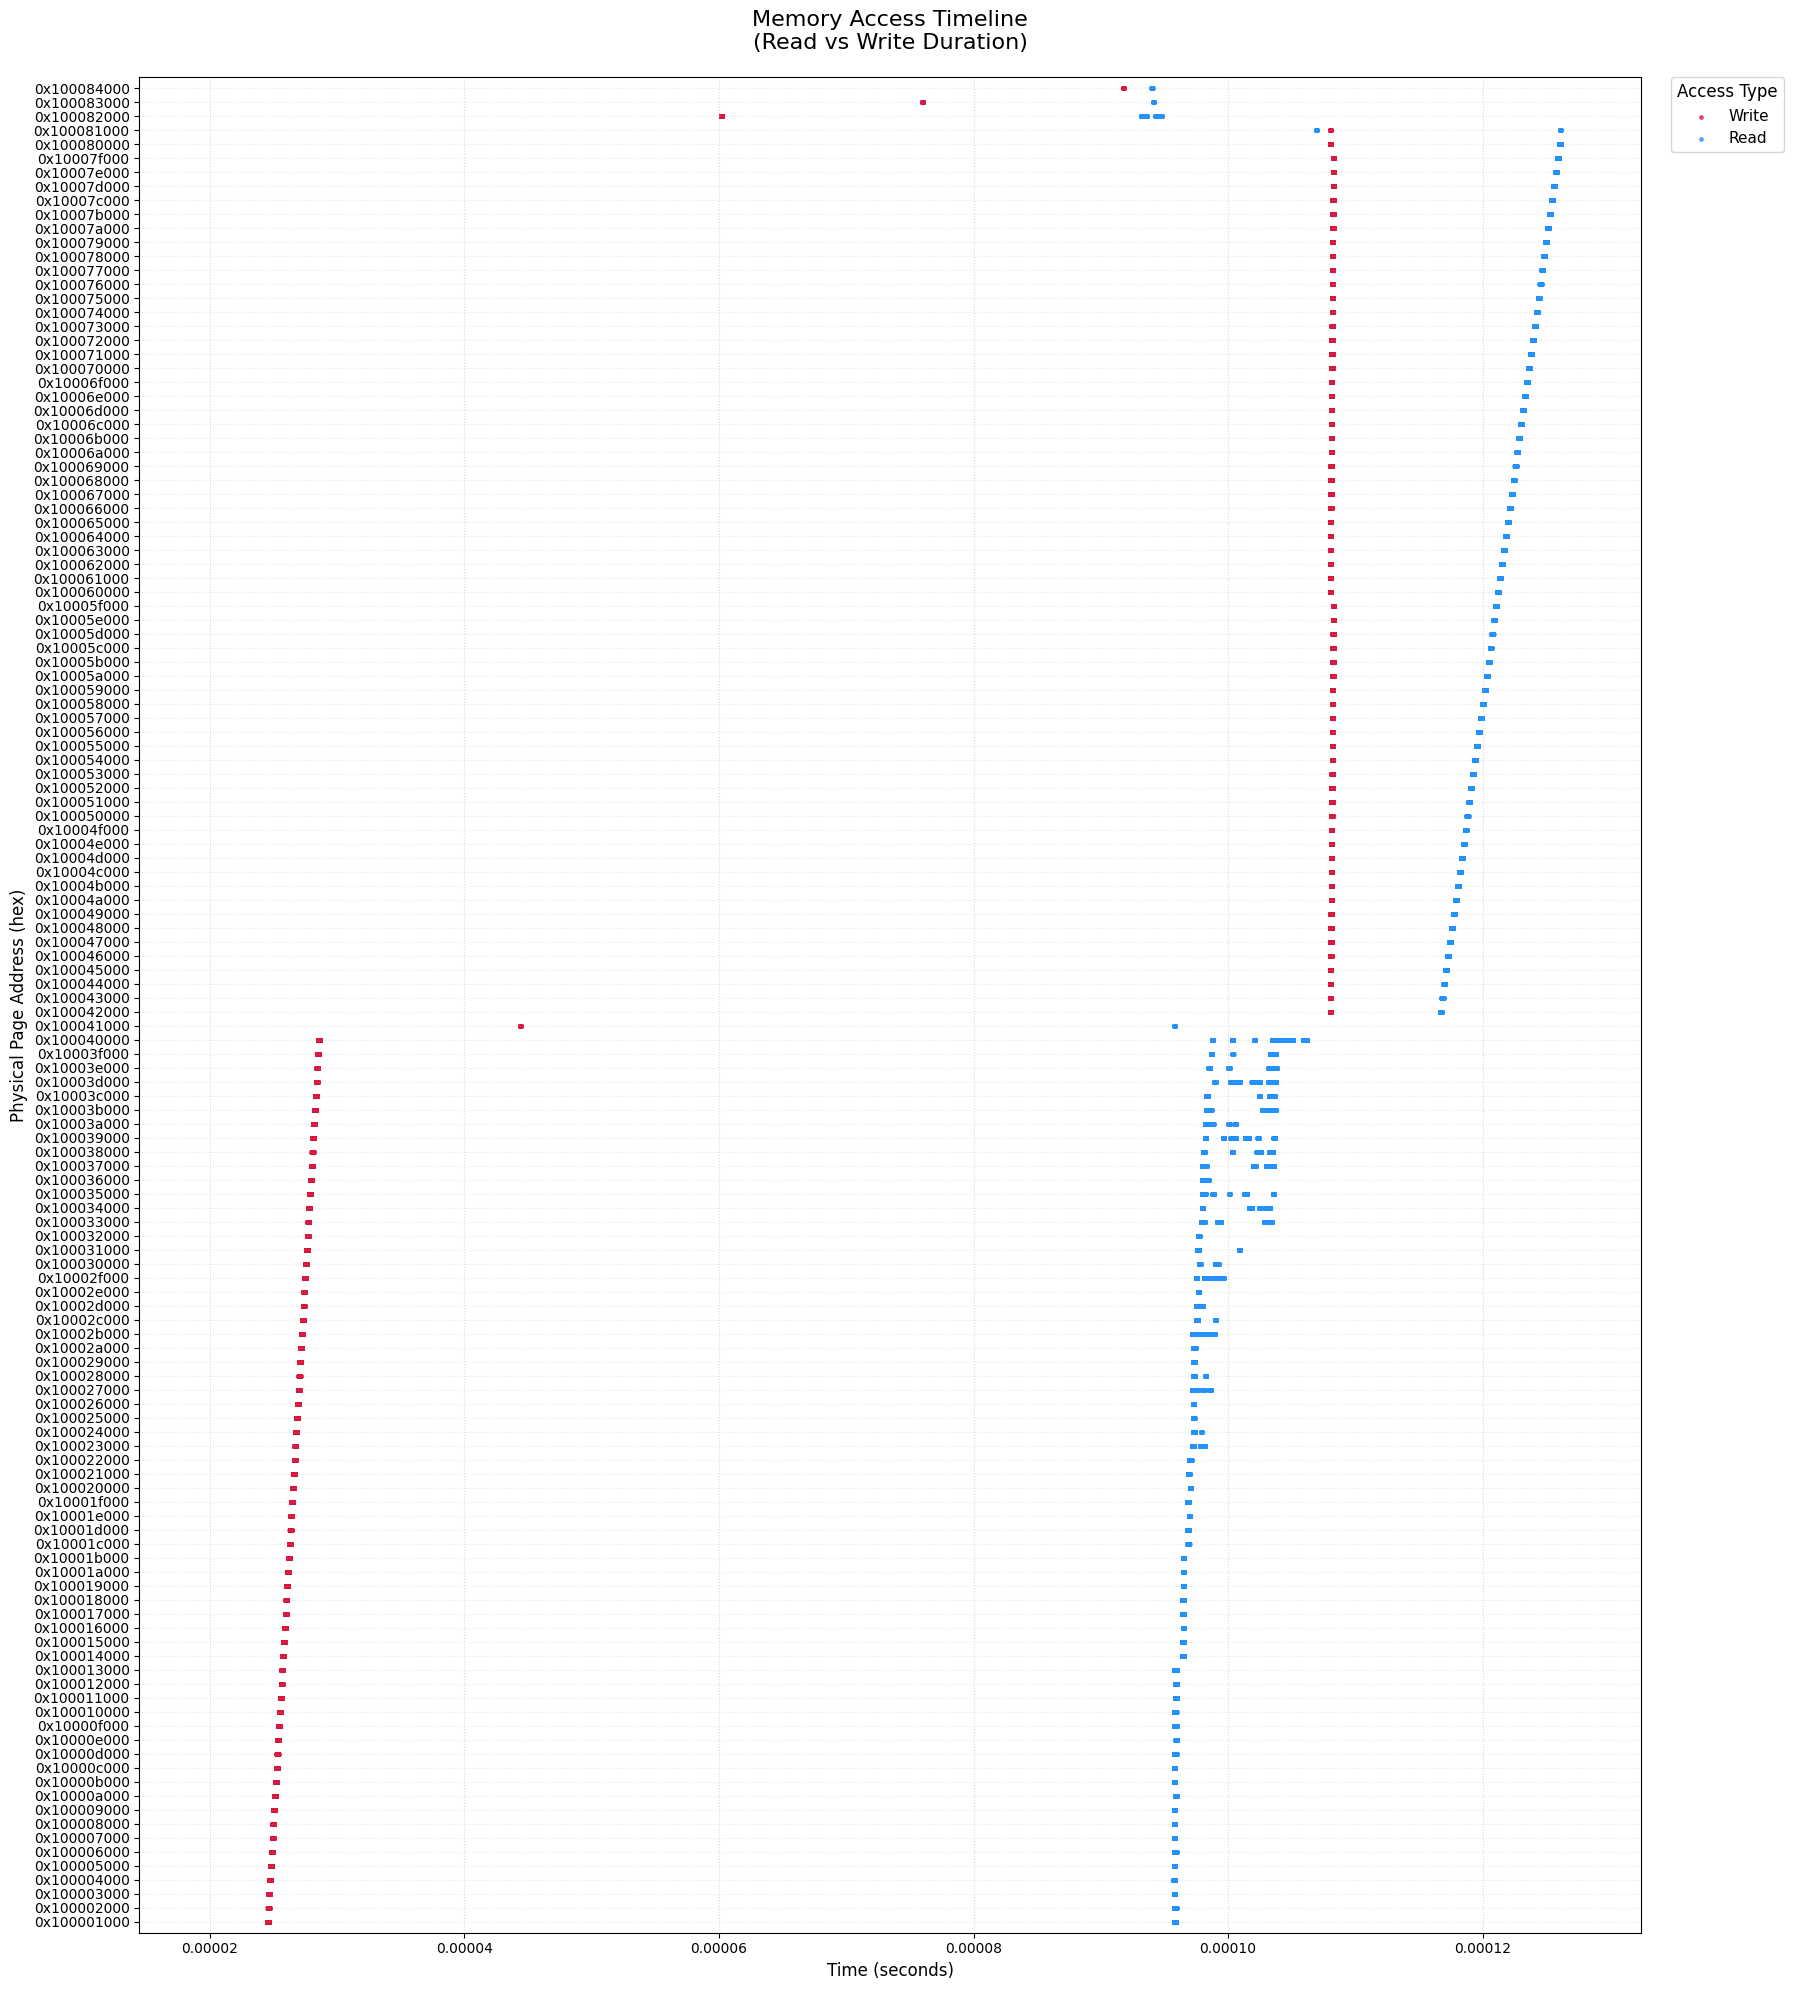

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 20))

# 创建统一的 y 轴映射（仅基于 rw_df 的 PageID）
all_pages = sorted(rw_df['PageID'].unique())
y_pos_map = {page: i for i, page in enumerate(all_pages)}

# 绘制每个读写访问的持续时间（横线）
for _, row in rw_df.iterrows():
    y_pos = y_pos_map[row['PageID']]
    
    # 根据访问类型选择颜色和样式
    if row['AccessType'] == '*mem.ReadReq':
        color = 'dodgerblue'
        linestyle = '-'  # 实线表示读
        label = 'Read' if _ == 0 or 'Read' not in plt.gca().get_legend_handles_labels()[1] else ''
    else:  # '*mem.WriteReq'
        color = 'crimson'
        linestyle = '--'  # 虚线表示写
        label = 'Write' if _ == 0 or 'Write' not in plt.gca().get_legend_handles_labels()[1] else ''
    
    # 生成在 StartTime 到 EndTime 之间的横向点
    x_points = np.linspace(row['StartTime'], row['EndTime'], num=20)
    y_points = np.full_like(x_points, y_pos)
    
    plt.scatter(
        x_points,
        y_points,
        color=color,
        s=6,           # 控制点的大小
        alpha=0.7,
        label=label
    )

    # 绘制横线（连接 StartTime 和 EndTime）
    # plt.hlines(
    #     y=y_pos,
    #     xmin=row['StartTime'],
    #     xmax=row['EndTime'],
    #     colors=color,
    #     linestyles=linestyle,
    #     alpha=0.7,
    #     linewidth=15,
    #     label=label
    # )
    
    # 可选：在访问的起点和终点添加标记
    # plt.scatter(
    #     row['StartTime'], y_pos,
    #     color=color,
    #     marker='>',  # 右箭头表示开始
    #     s=50,
    #     alpha=0.9,
    #     label=''  # 不重复添加图例
    # )
    # plt.scatter(
    #     row['EndTime'], y_pos,
    #     color=color,
    #     marker='<',  # 左箭头表示结束
    #     s=50,
    #     alpha=0.9,
    #     label=''
    # )

# 设置坐标轴
# plt.yticks(range(len(all_pages)), all_pages, fontsize=10) # y轴显示page id
plt.yticks(range(len(all_pages)), [hex(page * page_size_byte) for page in all_pages], fontsize=10) # y轴显示页物理地址
plt.xticks(fontsize=10)
plt.xlabel('Time (seconds)', fontsize=12)
# plt.ylabel('Page ID', fontsize=12) # y轴显示page id
plt.ylabel('Physical Page Address (hex)', fontsize=12) # y轴显示页物理地址
plt.title('Memory Access Timeline\n(Read vs Write Duration)', fontsize=16, pad=20)

# 调整坐标轴范围
min_time = rw_df['StartTime'].min()
max_time = rw_df['EndTime'].max()
plt.xlim(left=min_time - 0.00001, right=max_time * 1.05)
plt.ylim(bottom=-0.8, top=len(all_pages) - 0.2)

# 添加网格线
plt.grid(True, axis='x', linestyle=':', alpha=0.5)
plt.grid(True, axis='y', linestyle=':', alpha=0.3)

# 自定义图例（避免重复）
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))  # 去重
plt.legend(
    unique_labels.values(),
    unique_labels.keys(),
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0.,
    frameon=True,
    fontsize=11,
    title='Access Type',
    title_fontsize=12
)

# 调整布局
plt.subplots_adjust(right=0.85)
plt.tight_layout()

memory_access_path = os.path.join(results_dir, 'memory_access.png')
plt.savefig(memory_access_path, dpi=300, bbox_inches='tight')
plt.show()